In [2]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import mpu
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import math
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split

/home/milan/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Success targets

In [3]:
city        = 'london'
datafile    = 'FINAL_DATA'
successdata = datafile + '/london_venues_success_measures.csv'
venues      = [line.strip() for line in open(datafile + '/senior_venues_lists.dat')]


success  = pd.read_csv(successdata, sep = '\t', index_col = 0)
success  = success[~success.index.duplicated(keep='first')]   
success  = success[success.index.isin(venues)]


successdata_L = datafile + '/london_venues_success_measures_local_like.csv'
success_L     = pd.read_csv(successdata_L, sep = '\t', index_col = 0)
success_L     = success_L[~success_L.index.duplicated(keep='first')]   
success       = success.join(success_L)

success.index.name = 'venue'

success.head()                                         

,tipCount,checkinsCount,usersCount,Llikecount
venue,,,,
4a5f9446f964a520e0bf1fe3,75.0,2500.0,1831.0,33.195062
4abcec53f964a520b98720e3,17.0,1550.0,913.0,16.468388
4abdc1c7f964a5206d8b20e3,47.0,5573.0,2777.0,91.575568
4abe4502f964a520558c20e3,575.0,97190.0,80793.0,445.616354
4abe5714f964a520d68c20e3,54.0,1507.0,1256.0,49.789535


In [6]:
def get_success_Qs(segments, success, measure, randomized = False):

    if randomized: 
        np.random.shuffle(success[measure])
        
    labels = ['q' + str(i+1) for i in range(segments)]    
        
    success['quartile'] = pd.qcut(success[measure], segments, labels)
    Q1 = list(success[success['quartile'] == labels[0]].index)
    Q4 = list(success[success['quartile'] == labels[-1]].index)

    
    return Q4, Q1, success

VenuesTop, VenuesBottom, success = get_success_Qs(4, success, 'Llikecount', randomized = False)

### Get the features 

In [11]:
features_f = 'FINAL_FEATURES_UNCORR_BALANCED_ALL.csv'
features   = pd.read_csv(features_f, sep = '\t', index_col = 0)
features   = features[features.index.isin(venues)]
features   = features.dropna()
features   = features.drop(columns = ['LABEL_category'])


print len(features), len(features.keys())
features.head()

7940 12


,WHAT_pricerange,WHO_m_avg,WHO_fraction_of_regulars,WHERE_DistCentre,WHERE_IMDScore,WHERE_emb_own_cat,WHO_v_wa_clustering,WHO_v_wa_constraint,WHEN_firsttime,WHEN_hour_most,WHEN_day_most,WHO_female_fraction
venue,,,,,,,,,,,,
4a5f9446f964a520e0bf1fe3,2.0,1.836947,0.131579,0.000000,0.00,2.831711,0.0,1.0,1.342290e+09,19,1,0.302632
4abcec53f964a520b98720e3,0.0,1.997953,0.166667,79.164364,24.73,12.863672,0.0,0.0,1.340045e+09,10,0,0.303030
4abdc1c7f964a5206d8b20e3,2.0,1.809184,0.196721,875.514177,29.91,14.821463,0.0,0.0,1.343146e+09,18,0,0.277419
4abe4502f964a520558c20e3,0.0,1.797899,0.112536,79.164364,24.73,18.232509,0.0,0.0,1.346061e+09,21,1,0.439033
4abe5714f964a520d68c20e3,3.0,2.008383,0.225806,115.947206,20.48,3.733880,0.0,0.0,1.342808e+09,18,6,0.517241


# FILTER FEATUERS

### Classification

In [12]:
features_VenuesTop    = features[features.index.isin(VenuesTop)]
features_VenuesBottom = features[features.index.isin(VenuesBottom)]

features_VenuesTop['success']    = 1
features_VenuesBottom['success'] = 0

X = features_VenuesTop.append(features_VenuesBottom)
y = np.asarray(X.success)
X = X.drop(columns = ['success'])

X = X.round(3)
X.head()

/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,WHAT_pricerange,WHO_m_avg,WHO_fraction_of_regulars,WHERE_DistCentre,WHERE_IMDScore,WHERE_emb_own_cat,WHO_v_wa_clustering,WHO_v_wa_constraint,WHEN_firsttime,WHEN_hour_most,WHEN_day_most,WHO_female_fraction
venue,,,,,,,,,,,,
4abdc1c7f964a5206d8b20e3,2.0,1.809,0.197,875.514,29.91,14.821,0.0,0.0,1.343146e+09,18,0,0.277
4abe4502f964a520558c20e3,0.0,1.798,0.113,79.164,24.73,18.233,0.0,0.0,1.346061e+09,21,1,0.439
4abe5714f964a520d68c20e3,3.0,2.008,0.226,115.947,20.48,3.734,0.0,0.0,1.342808e+09,18,6,0.517
4abf8c03f964a520079120e3,0.0,1.935,0.204,0.000,0.00,9.957,0.0,0.0,1.339089e+09,20,0,0.483
4ac4bb54f964a520e49e20e3,2.0,1.908,0.203,115.947,20.48,3.227,0.0,1.0,1.339072e+09,10,2,0.557


In [14]:
def classifiers(X, y, depth_ = 5):
       
    classifier = RandomForestClassifier(max_depth=depth_, n_estimators=1000, max_features='auto') 

    
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.33, random_state=42)

    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    return np.mean(cross_val_score(classifier, X_train, y_train, cv=10))

        
classifiers(X, y, 5)

0.8609354340448752

Text(0.5,0,'depth')

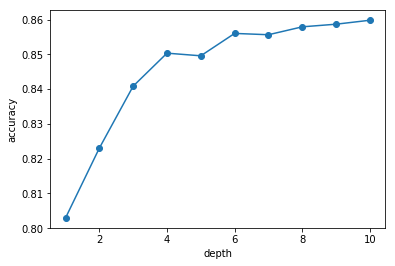

In [75]:
xx = []
yy = []

for d in [1,2,3,4,5,6,7,8,9, 10]:
    xx.append(d)
    yy.append(classifiers(X, y, depth_ = d))
    
plt.plot(xx, yy, 'o-')
plt.ylabel('accuracy')
plt.xlabel('depth')
    

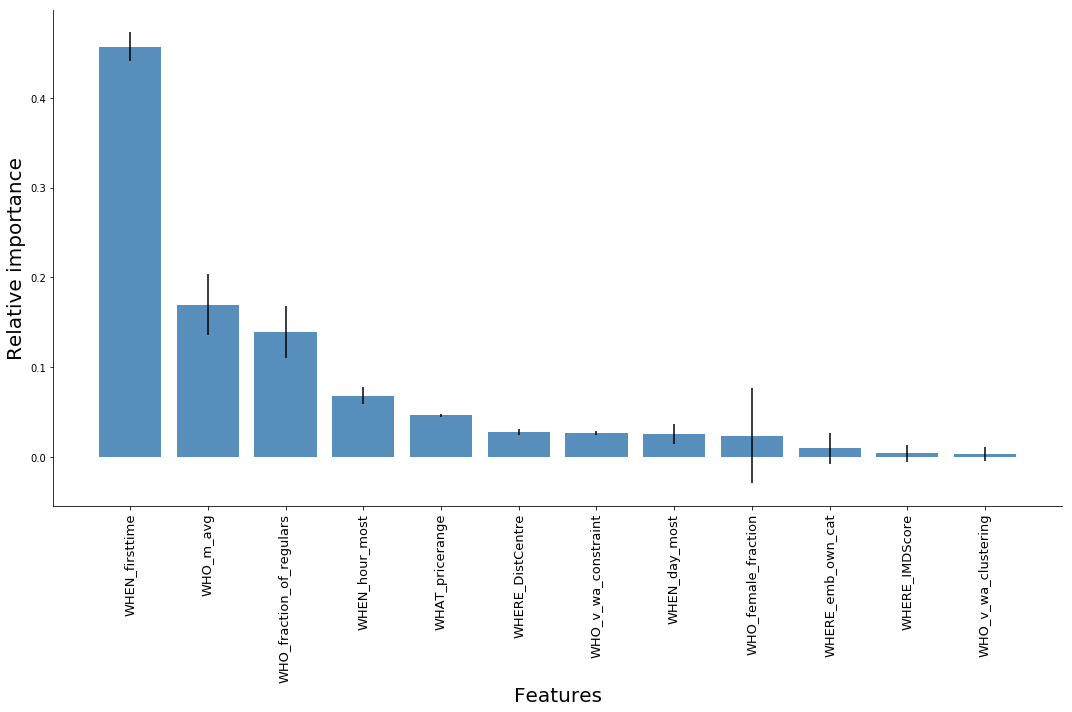

In [16]:
def importance(X, y):
   

    classifier = RandomForestClassifier(max_depth=5, n_estimators=1000, max_features='auto') 
    classifier.fit(X, y)    
    X_head = X.keys()
    
    importances = classifier.feature_importances_
    std         = np.std([tree.feature_importances_ / math.sqrt(len(tree.feature_importances_)) for tree in classifier.estimators_], axis=0)
    indices     = np.argsort(importances)[::-1]

    df = pd.DataFrame()
    df['ind'], df['val'], xlabels = zip(*[(X_head[i], importances[i], X_head[i]) for i in indices])

    
    df    = df.sort_values(['val'], ascending = True)
    f, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    impy = [i for i in importances[indices]]

    ax.bar(range(len(impy)), impy, yerr= std, color="steelblue", alpha = 0.9, align="center")

    ax.set_xticks(range(len(impy)))
    ax.set_xticklabels(xlabels, rotation = 90, fontsize = 13)

    ax.set_ylabel('Relative importance', fontsize = 20)
    ax.set_xlabel('Features', fontsize = 20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.savefig('FINAL_FIGURES/1_features_importance_all.png')
    plt.tight_layout()
    
    
    fout = open('FINAL_DATA/BINARYCLASS_IMPORTANCE.dat', 'w')
    
    for i in range(len(impy)):
        fout.write(str(xlabels[i]) + '\t' + str(impy[i]) + '\t' + str(std[i]) + '\n')
    fout.close()
 
    return importances[indices], xlabels

importances, imp_features = importance(X, y)

In [18]:
def classifiers_types(X, y, tipus = '', randomize = False):
   

    classifier = RandomForestClassifier(max_depth=5, n_estimators=1000, max_features='auto') 
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.33, random_state=42)

    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    meanc = np.mean(cross_val_score(classifier, X_train, y_train, cv=10))
    
    if tipus == '':
        tipus = 'ALL'

    

    return  meanc
        
    
when   = classifiers_types(X, y, tipus = 'WHEN',  randomize = False)
allf   = classifiers_types(X, y, tipus = '', randomize = False)
where  = classifiers_types(X, y, tipus = 'WHERE', randomize = False)
who    = classifiers_types(X, y, tipus = 'WHO',   randomize = False)
what   = classifiers_types(X, y, tipus = 'WHAT',  randomize = False)



fout = open('FINAL_DATA/BINARYCLASS_COMPARISON.dat', 'w')
fout.write('ALL\t'   + str(allf)   + '\n')
fout.write('WHERE\t' + str(where)  + '\n')
fout.write('WHO\t'   + str(who)    + '\n')
fout.write('WHAT\t'  + str(what)   + '\n')
fout.write('WHEN\t'  + str(when)   + '\n')

fout.close()


In [116]:
def classifiers_top(X, y,  imp_features, n, m):
   
    y_ = np.asarray(list(y))
    X_ = X.drop(columns = [  c for c in X.keys() if c  in imp_features[n:m]  ]) 
    
    print len(X_.keys())
   
    classifier = RandomForestClassifier(max_depth=3, n_estimators=100, max_features='auto') 
    X_train, X_test, y_train, y_test =  train_test_split(X_, y, test_size=.33, random_state=42)

    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    meanc = np.mean(cross_val_score(classifier, X_train, y_train, cv=3))
    print  'CrossCalScore\t', score, meanc

    return meanc




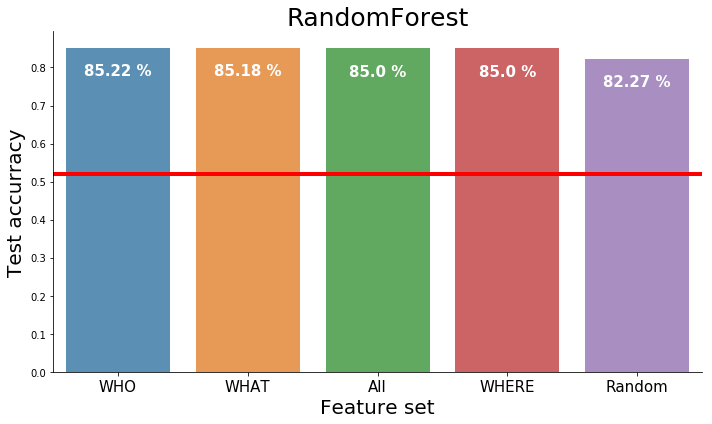

In [79]:
%matplotlib inline
df = pd.DataFrame()
df['ind'] = ['All','WHO', 'WHERE', 'WHAT', 'Random']
df['val'] = [allf, who, where, what, rand]
df        = df.sort_values(['val'], ascending = False)


f, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x="ind", y="val", data=df, ax = ax, alpha = 0.8, capsize=.2 )
ax.set_ylabel('Test accurracy', fontsize = 20)
ax.set_xlabel('Feature set', fontsize = 20)
ax.set_xticklabels(df['ind'], fontsize = 15)
#ax.set_yticklabels(['0%', '10%','20%','30%','40%', '50%', '60%'], fontsize = 15)

ax.axhline(y = 0.52, linewidth=4, color='r')
ax.set_title('RandomForest', fontsize = 25)
rects = ax.patches

for rect, label in zip(rects, df['val']):
    height = rect.get_height()
    label = str(round(100*label, 2)) + ' %'
    ax.text(rect.get_x() + rect.get_width() / 2, height-0.08 , label,ha='center', weight = 'bold', va='bottom', color = 'white', fontsize = 15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('FINAL_FIGURES/2_features_accuracy.png')
plt.show()



## for all the features do this plot one by one!!!

In [172]:
def classifiers_you_sure(X, y, randomize = False):
   
    aavalues = {}

    if randomize: 
        random.shuffle(y)
        
     
        
    X_ = X.drop(columns = [ c for c in X.keys()  if 'lLondonLike' in c or 'tipCount' in c  or 'usersCount' in c or 'checkinsCount' in c])
    keys = X_.keys()#[  c for c in X.keys() if 'WHO' in c  ]    

    #X_ = X.drop(columns = ['WHO_m_entropy'])    
        
    
    for ind, key in enumerate(keys):
      

       # if ind == 10: break

        XX_ = pd.DataFrame(X_[key])

       #print list(X_[key])
        classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto') 
        # preprocess dataset, split into training and test part
        # X = StandardScaler().fit_transform(X)
        # X = preprocessing.quantile_transform(X, output_distribution = 'normal')
        X_train, X_test, y_train, y_test =  train_test_split(XX_, y, test_size=.33, random_state=42)

        # iterate over classifiers
        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        meanc = np.mean(cross_val_score(classifier, X_train, y_train, cv=3))
        #print  key, '\t\t', round(score,2)#, meanc


        aavalues[key]  = meanc

    return aavalues
        

aavalues = classifiers_you_sure(X, y, randomize = False)


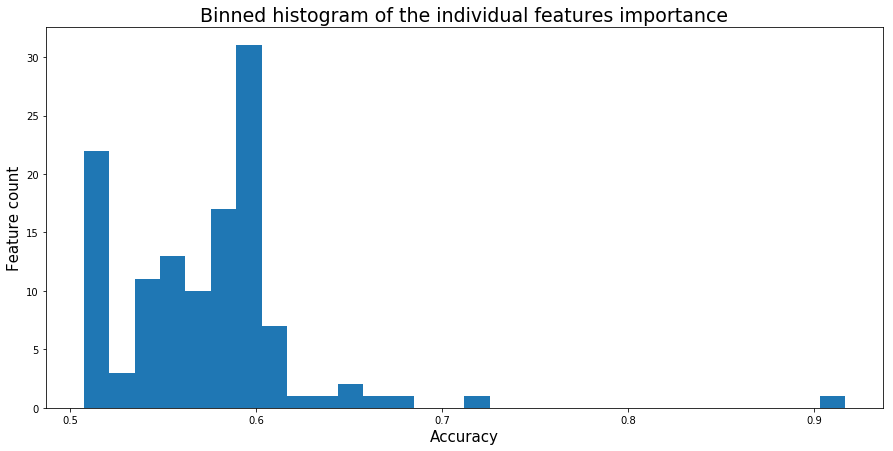

In [173]:
f, ax = plt.subplots(1,1, figsize = (15,7))
ax.hist(aavalues.values(), bins = 30)
ax.set_title('Binned histogram of the individual features importance', fontsize = 19)
ax.set_xlabel('Accuracy', fontsize = 15)
ax.set_ylabel('Feature count', fontsize = 15)
plt.savefig('FINAL_FIGURES/4_individual_features_importance.png')

In [174]:
data = [(k, v ) for k, v in aavalues.items()]
sorted_by_second = sorted(data, key=lambda tup: tup[1], reverse = True)

for (k, v) in sorted_by_second:
    print round(v, 3), '\t', k
    

0.917 	WHO_m_entropy
0.719 	WHO_fraction_of_regulars
0.678 	WHO_m_1_fraction
0.663 	WHO_m_avg
0.649 	WHO_v_social_std
0.645 	WHO_m_2_fraction
0.632 	WHAT_pricerange
0.629 	WHO_m_3_fraction
0.613 	WHO_v_social_stretch
0.611 	WHERE_NoOwndDwel
0.611 	WHERE_user_centroids
0.605 	WHERE_DistCentre
0.605 	WHERE_NoHouses
0.603 	WHERE_NoFlats
0.603 	WHERE_z_distCent1
0.602 	WHERE_z_NoOwndDwel_ratio
0.6 	WHERE_No4sqCheck
0.599 	WHERE_zt_ArtsEmploy_ratio
0.599 	WHERE_PTALScore
0.599 	WHERE_zt_NoEmployee_ratio
0.597 	WHERE_zt_PTALScore
0.595 	WHO_m_4_fraction
0.595 	WHERE_zt_NoOSPOIs
0.595 	WHERE_NoEmployee
0.594 	WHERE_PopDen
0.594 	WHERE_z_NoHouses_ratio
0.594 	WHERE_sub_region
0.594 	WHERE_Venues_num
0.594 	WHO_v_wa_degree
0.594 	WHO_v_wa_constraint
0.594 	WHO_v_wa_egosize
0.593 	WHERE_zt_PopDen
0.593 	WHERE_NotBornUK
0.592 	WHERE_NoOSPOIs
0.592 	WHO_v_wa_constraint_wa
0.592 	WHO_v_wa_constraint_exp_distances
0.592 	WHO_v_wa_geo_social_stretch_grav_distances
0.592 	WHO_v_wa_constraint_inv_dista

# GET DIFFERENT TRAJECTORIES AS EXAMPLES

In [91]:
rise_venues_top = [line.strip().split('\t')[0] for line in open(datafile + '/senior_5_13/clustering_results/sorted_dist_venues_in_rise.dat') if line.strip().split('\t')[0] in VenuesTop]
fall_venues_top = [line.strip().split('\t')[0] for line in open(datafile + '/senior_5_13/clustering_results/sorted_dist_venues_in_fall.dat') if line.strip().split('\t')[0] in VenuesTop]

In [51]:
maturity   = 'senior_5_13'
method     = 'complete'
city       = 'london'
datafile   = 'FINAL_DATA/'
outfolder  = '../../ProcessedData/' + city + '/timeseries/' + maturity  
infile     = '../../ProcessedData/' + city + '/timeseries/senior_timeseries_5_13.dat'
venues_ts  = {}
lengths    = []

for ind, line in enumerate(open(infile)):
    fields = line.strip().split('\t')
    venue  = fields[0]
    ts     = fields[1:]
    venues_ts[venue] = savgol_filter(np.asarray([float(fff) for fff in ts  ] ), 5, 3) 
    lengths.append(len(ts))
    
print ind
len(venues_ts)

8378


8379

tipCount              33
checkinsCount       4167
usersCount          2835
Llikecount       46.6846
quartile              q4
Name: 4bd462419854d13a0573ff4d, dtype: object

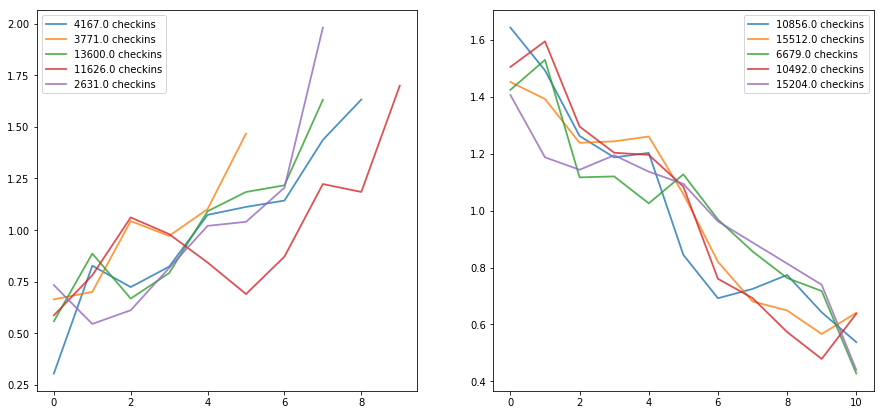

In [108]:
f, ax = plt.subplots(1,2, figsize = (15,7))

for v in rise_venues_top[0:5]:
    label = str(success.loc[v].checkinsCount) + ' checkins'
    ax[0].plot(venues_ts[v], linewidth = 1.8, alpha = 0.8, label = label)  
    ax[0].legend(loc = 'best')
 
for v in fall_venues_top[0:5]:
    label = str(success.loc[v].checkinsCount) + ' checkins'
    ax[1].plot(venues_ts[v], linewidth = 1.8, alpha = 0.8, label = label)  
    ax[1].legend(loc = 'best')
   


plt.savefig('FINAL_FIGURES/3_different_success.png')